## Data Preprocessing & Modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("data_baseline.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374133 entries, 0 to 1374132
Data columns (total 29 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1374133 non-null  int64  
 1   idperson               1374133 non-null  float64
 2   bankid                 1374133 non-null  int64  
 3   loan_type              1374133 non-null  int64  
 4   currency               1374133 non-null  object 
 5   price_nom              1374133 non-null  float64
 6   price_real             1374133 non-null  float64
 7   risk_class             1374133 non-null  int64  
 8   classified             1374133 non-null  float64
 9   year                   1374133 non-null  float64
 10  month                  1374133 non-null  float64
 11  quarter                1374133 non-null  float64
 12  maturity               1374133 non-null  float64
 13  education              1374133 non-null  object 
 14  family_members    

In [4]:
data['gender'] = data['gender'].map({'M': 0, 'F': 1})
data['ispe'] = data['ispe'].map({'N': 0, 'Y': 1})
data['marital_status'] = data['marital_status'].map({'Married': 1, 'Single': 0})

In [5]:
value_counts1 = data['classified'].value_counts()
total1 = value_counts1.sum()

value_counts2 = data['Default'].value_counts()
total2 = value_counts2.sum()

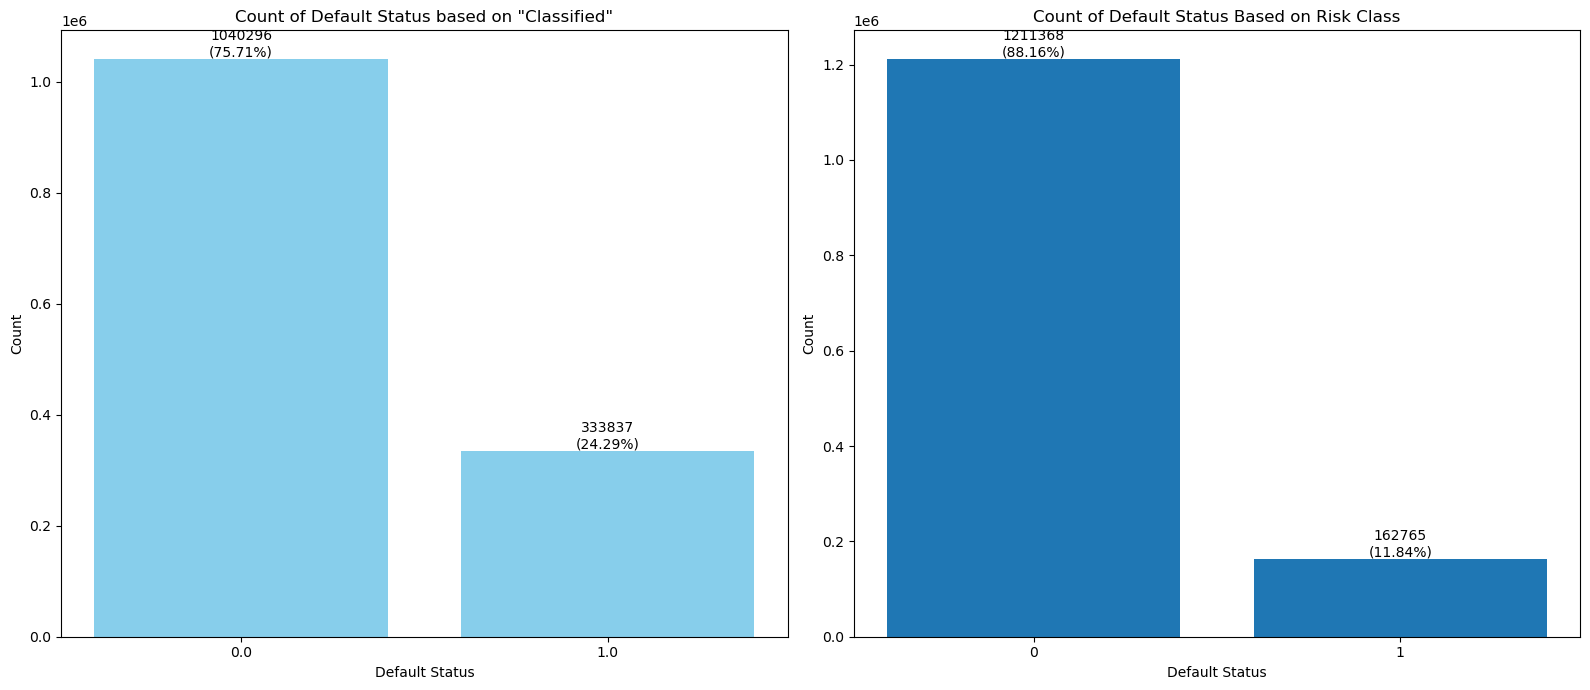

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

bars1 = axes[0].bar(value_counts1.index.astype(str), value_counts1.values, color='skyblue')
axes[0].set_xlabel('Default Status')
axes[0].set_ylabel('Count')
axes[0].set_title('Count of Default Status based on "Classified"')
axes[0].set_xticks(value_counts1.index.astype(str))
axes[0].set_xticklabels(value_counts1.index.astype(str), rotation=0)

for bar in bars1:
    yval = bar.get_height()
    percentage = f'{(yval / total1 * 100):.2f}%'
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}\n({percentage})', ha='center', va='bottom')

bars2 = axes[1].bar(value_counts2.index.astype(str), value_counts2.values)
axes[1].set_xlabel('Default Status')
axes[1].set_ylabel('Count')
axes[1].set_title('Count of Default Status Based on Risk Class')
axes[1].set_xticks(value_counts2.index.astype(str))
axes[1].set_xticklabels(value_counts2.index.astype(str), rotation=0)

for bar in bars2:
    yval = bar.get_height()
    percentage = f'{(yval / total2 * 100):.2f}%'
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}\n({percentage})', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [71]:
data = data[[
 'bankid',
 'loan_type',
 'currency',
 'price_nom',
 'price_real',
 'risk_class',
 'year',
 'month',
 'quarter',
 'maturity',
 'education',
 'family_members',
 'gender',
 'ispe',
 'marital_status',
 'last_reclass_date_bin',
 'overdue_date_bin',
 'amountAMD',
 'Age',
 'has_fico_score',
 'has_income',
 'score_exists',
 'previous_loans',
 'Default']]

<Axes: >

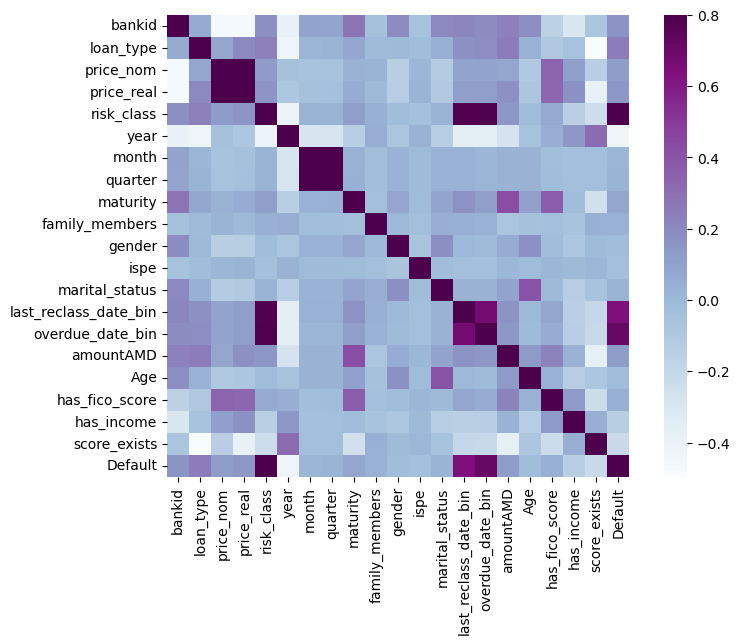

In [72]:
matrix = data.corr()
f, ax = plt.subplots(figsize = (9, 6))
sns.heatmap(matrix, vmax = .8, square = True, cmap = "BuPu")

We can see that some variables are highly correlated with each other, thus we remove one of them and keep only one.
There is a high correlation between month, quarter, so we only keep quarter.
From overdue_date_bin and last_reclass_date_bin, we only keep overdue_date_bin.
Also we remove risk_class, since the default parameter was calculated based on risk class.

In [13]:
data1 = data[[
 'bankid',
 'loan_type',
 'currency',
 'price_real',
 'year',
 'quarter',
 'maturity',
 'education',
 'family_members',
 'gender',
 'ispe',
 'marital_status',
 'overdue_date_bin',
 'amountAMD',
 'Age',
 'has_fico_score',
 'has_income',
 'score_exists',
 'previous_loans',
 'Default']]

<Axes: >

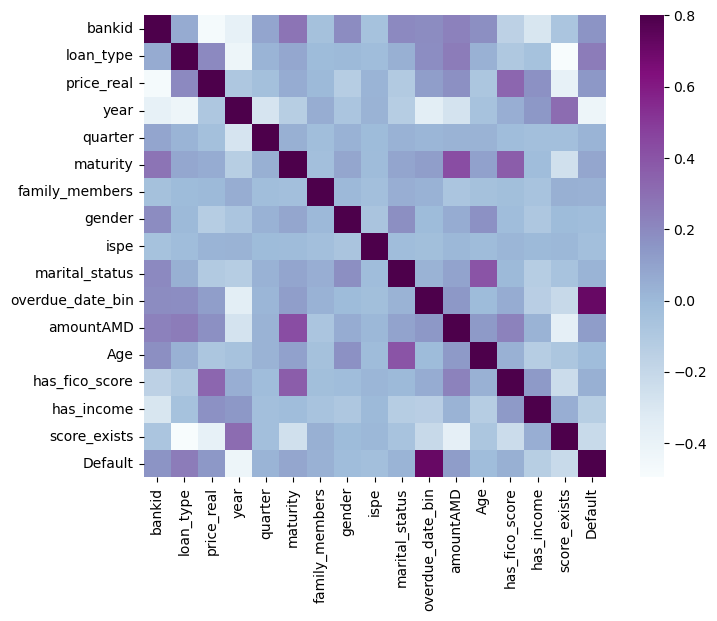

In [14]:
matrix = data1.corr()
f, ax = plt.subplots(figsize = (9, 6))
sns.heatmap(matrix, vmax = .8, square = True, cmap = "BuPu")

##### Numeric Columns
maturity, family_members, amountAMD, age, price_real
##### Categorical Columns
bankid, loan_type, currency, education, previous_loans, year, quarter
##### Dependent Variable
default

In [15]:
Q1 = data1['maturity'].quantile(0.25) #quantile 1
Q3 = data1['maturity'].quantile(0.75) #quantile 3

IQR = Q3 - Q1 

lower_bound = Q1-1.5*IQR
upper_bound = Q3 + 1.5 * IQR

In [16]:
print(data1['maturity'][data1['maturity'] < lower_bound].count())
print(data1['maturity'][data1['maturity'] > upper_bound].count())

1824
34564


In [17]:
data1 = data1[(data1['maturity'] >= lower_bound) & (data1['maturity'] <= upper_bound)]
data1.reset_index(inplace = True, drop = True)

In [18]:
df_encoded = pd.get_dummies(data1, columns = ['bankid', 'loan_type', 'currency', 'education', 'previous_loans', 'year', 'quarter'])

In [19]:
df_encoded.columns.tolist()

['price_real',
 'maturity',
 'family_members',
 'gender',
 'ispe',
 'marital_status',
 'overdue_date_bin',
 'amountAMD',
 'Age',
 'has_fico_score',
 'has_income',
 'score_exists',
 'Default',
 'bankid_11500',
 'bankid_11800',
 'bankid_15100',
 'bankid_15700',
 'bankid_16000',
 'bankid_16300',
 'bankid_16600',
 'bankid_19300',
 'bankid_20500',
 'bankid_20800',
 'bankid_21400',
 'bankid_21700',
 'bankid_22000',
 'bankid_24100',
 'bankid_24700',
 'bankid_25000',
 'loan_type_1',
 'loan_type_2',
 'loan_type_3',
 'loan_type_5',
 'loan_type_7',
 'loan_type_9',
 'loan_type_15',
 'currency_AMD',
 'currency_EUR',
 'currency_USD',
 'education_Bachelor',
 'education_Doctorate',
 'education_Lower Secondary',
 'education_Master',
 'education_No Edu',
 'education_Primary',
 'education_Tertiary',
 'education_Upper Secondary',
 'previous_loans_No Loans',
 'previous_loans_more than 10',
 'previous_loans_up to 5',
 'year_2005.0',
 'year_2007.0',
 'year_2008.0',
 'year_2009.0',
 'year_2010.0',
 'year_2011

#### Standardization/Scaling

We must scale numerical features before fitting the logistic regression model. Scaling these features helps ensure that no single feature disproportionately influences the model due to its range. For logistic regression, standard scaling (normalizing to zero mean and unit variance) is generally recommended.

In [21]:
X = df_encoded.drop('Default', axis=1)
y = df_encoded['Default']

In [22]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [23]:
numeric_cols = ['maturity', 'family_members', 'amountAMD', 'Age', 'price_real']
binary_cols = ['gender',
 'ispe',
 'marital_status',
 'overdue_date_bin',
 'has_fico_score',
 'has_income',
 'score_exists',
 'bankid_11500',
 'bankid_11800',
 'bankid_15100',
 'bankid_15700',
 'bankid_16000',
 'bankid_16300',
 'bankid_16600',
 'bankid_19300',
 'bankid_20500',
 'bankid_20800',
 'bankid_21400',
 'bankid_21700',
 'bankid_22000',
 'bankid_24100',
 'bankid_24700',
 'bankid_25000',
 'loan_type_1',
 'loan_type_2',
 'loan_type_3',
 'loan_type_5',
 'loan_type_7',
 'loan_type_9',
 'loan_type_15',
 'currency_AMD',
 'currency_EUR',
 'currency_USD',
 'education_Bachelor',
 'education_Doctorate',
 'education_Lower Secondary',
 'education_Master',
 'education_No Edu',
 'education_Primary',
 'education_Tertiary',
 'education_Upper Secondary',
 'previous_loans_No Loans',
 'previous_loans_more than 10',
 'previous_loans_up to 5',
 'year_2005.0',
 'year_2007.0',
 'year_2008.0',
 'year_2009.0',
 'year_2010.0',
 'year_2011.0',
 'year_2012.0',
 'year_2013.0',
 'year_2014.0',
 'year_2015.0',
 'year_2016.0',
 'year_2017.0',
 'year_2018.0',
 'year_2019.0',
 'year_2020.0',
 'year_2021.0',
 'quarter_1.0',
 'quarter_2.0',
 'quarter_3.0',
 'quarter_4.0']

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),  # Apply standard scaling to numeric columns
        ('bin', 'passthrough', binary_cols)       # Pass through binary columns
    ])

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [26]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_val_pred = lr_model.predict(X_val)
print(f"Training Accuracy: {lr_model.score(X_train, y_train)}")
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

Training Accuracy: 0.94516518469514
Validation Accuracy: 0.9452735760552272
Validation Confusion Matrix:
 [[228598   8027]
 [  6615  24309]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97    236625
           1       0.75      0.79      0.77     30924

    accuracy                           0.95    267549
   macro avg       0.86      0.88      0.87    267549
weighted avg       0.95      0.95      0.95    267549



#### Hyperparameter Tuning with Grid Search

In [27]:
param_grid = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l2'],
    'solver': ['saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, verbose=0, scoring='accuracy', n_jobs = -1)
grid_search.fit(X_train, y_train)

best_lr = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

y_val_pred_best = best_lr.predict(X_val)
print("Tuned Validation Accuracy:", accuracy_score(y_val, y_val_pred_best))
print("Tuned Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_best))
print("Tuned Validation Classification Report:\n", classification_report(y_val, y_val_pred_best))

Best parameters: {'C': 1000.0, 'penalty': 'l2', 'solver': 'saga'}
Tuned Validation Accuracy: 0.9452623631559078
Tuned Validation Confusion Matrix:
 [[228614   8011]
 [  6634  24290]]
Tuned Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97    236625
           1       0.75      0.79      0.77     30924

    accuracy                           0.95    267549
   macro avg       0.86      0.88      0.87    267549
weighted avg       0.95      0.95      0.95    267549



#### Final Evaluation on Test Set

In [28]:
y_test_pred = best_lr.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Set Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Test Set Classification Report:\n", classification_report(y_test, y_test_pred))

Test Set Accuracy: 0.9455277351064665
Test Set Confusion Matrix:
 [[228538   8087]
 [  6487  24437]]
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97    236625
           1       0.75      0.79      0.77     30924

    accuracy                           0.95    267549
   macro avg       0.86      0.88      0.87    267549
weighted avg       0.95      0.95      0.95    267549



In [30]:
y_prob = best_lr.predict_proba(X_test)[:, 1]  

auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc_score}")

AUC: 0.9684386254992644


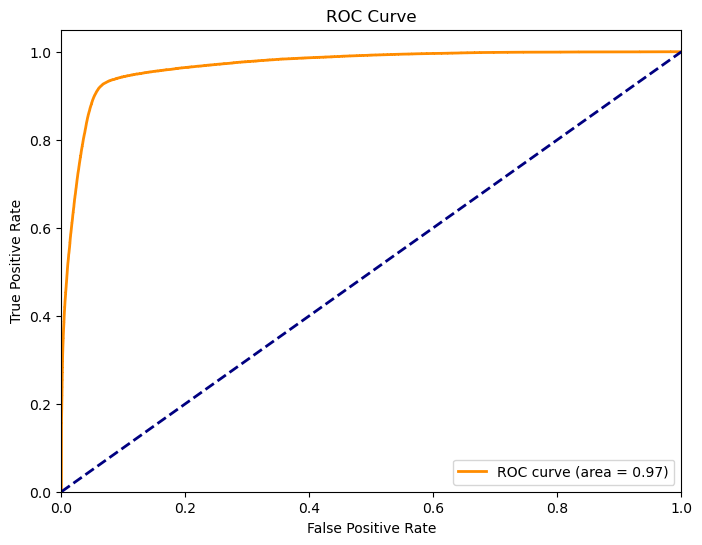

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [152]:
feature_names = X.columns 
coefficients = best_lr.coef_[0]

importance = pd.Series(coefficients, index=feature_names).sort_values(key=abs, ascending=False)

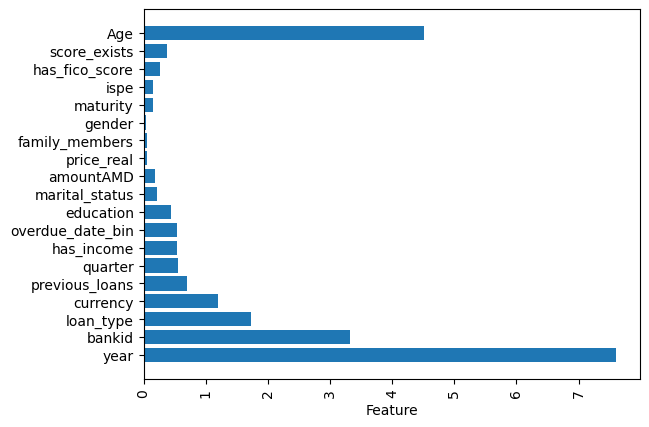

In [155]:
data_test = pd.DataFrame({'Feature' : feature_names, 'Coefficient': coefficients})
def aggregate_features(row):
    if 'year' in row['Feature']:
        return 'year'
    elif 'bankid' in row['Feature']:
        return 'bankid'
    elif 'quarter' in row['Feature']:
        return 'quarter'
    elif 'loan_type' in row['Feature']:
        return 'loan_type'
    elif 'currency' in row['Feature']:
        return 'currency'
    elif 'education' in row['Feature']:
        return 'education'
    elif 'previous_loans' in row['Feature']:
        return 'previous_loans'    
    else: 
        return row['Feature']
    
data_test['Feature'] = data_test.apply(aggregate_features, axis = 1)
data_test = data_test.sort_values('Coefficient')
data_test['Coefficient'] = data_test['Coefficient'].abs()
data_test.reset_index(inplace = True, drop = True)
plt.barh(data_test['Feature'], data_test['Coefficient'])
plt.xlabel('Feature')
plt.xticks(rotation = 90)
plt.show()

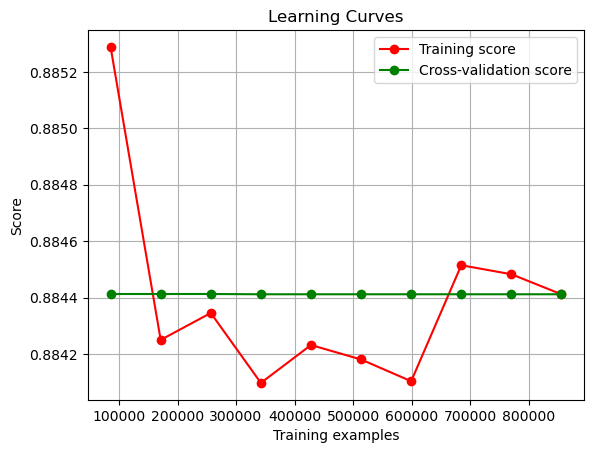

In [36]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=LogisticRegression(), X=X_train_val, y=y_train_val,
    train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.show()

In [37]:
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(LogisticRegression(), X_train_val, y_train_val, cv=5)
print("Cross-Validation Scores:", cross_val_scores)
print("Average Cross-Validation Score:", np.mean(cross_val_scores))

Cross-Validation Scores: [0.88441413 0.88442293 0.88440892 0.88440892 0.88440424]
Average Cross-Validation Score: 0.8844118273640522


## Random Forest

In [40]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

y_val_pred_rf = rf_model.predict(X_val)

print("Random Forest Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("Random Forest Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_rf))
print("Random Forest Validation Classification Report:\n", classification_report(y_val, y_val_pred_rf))

Random Forest Validation Accuracy: 0.957566651342371
Random Forest Validation Confusion Matrix:
 [[231742   4883]
 [  6470  24454]]
Random Forest Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98    236625
           1       0.83      0.79      0.81     30924

    accuracy                           0.96    267549
   macro avg       0.90      0.89      0.89    267549
weighted avg       0.96      0.96      0.96    267549



In [41]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],  # number of trees in the forest
    'max_depth': [None, 10, 20],  # maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # minimum number of samples required to split an internal node
}

# Initialize the GridSearchCV object
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, verbose=0, scoring='accuracy')

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

# Best estimator
best_rf = grid_search_rf.best_estimator_
print("Best parameters:", grid_search_rf.best_params_)

# Predict on the validation set using the best parameters
y_val_pred_best_rf = best_rf.predict(X_val)

# Evaluate the best Random Forest model
print("Tuned Random Forest Validation Accuracy:", accuracy_score(y_val, y_val_pred_best_rf))
print("Tuned Random Forest Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_best_rf))
print("Tuned Random Forest Validation Classification Report:\n", classification_report(y_val, y_val_pred_best_rf))

Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Tuned Random Forest Validation Accuracy: 0.9588860358289509
Tuned Random Forest Validation Confusion Matrix:
 [[231708   4917]
 [  6083  24841]]
Tuned Random Forest Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98    236625
           1       0.83      0.80      0.82     30924

    accuracy                           0.96    267549
   macro avg       0.90      0.89      0.90    267549
weighted avg       0.96      0.96      0.96    267549



In [42]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, RocCurveDisplay

def evaluate_model_performance(model, X, y, model_name='Model'):
    # Predictions
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # probabilities for the positive class

    # Metrics
    accuracy = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary')
    print(f"{model_name} - Accuracy: {accuracy:.4f}")
    print(f"{model_name} - Precision: {precision:.4f}")
    print(f"{model_name} - Recall: {recall:.4f}")
    print(f"{model_name} - F1 Score: {f1:.4f}")

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name).plot()
    plt.show()

    return accuracy, precision, recall, f1, roc_auc

Logistic Regression - Accuracy: 0.9455
Logistic Regression - Precision: 0.7514
Logistic Regression - Recall: 0.7902
Logistic Regression - F1 Score: 0.7703


<Figure size 640x480 with 0 Axes>

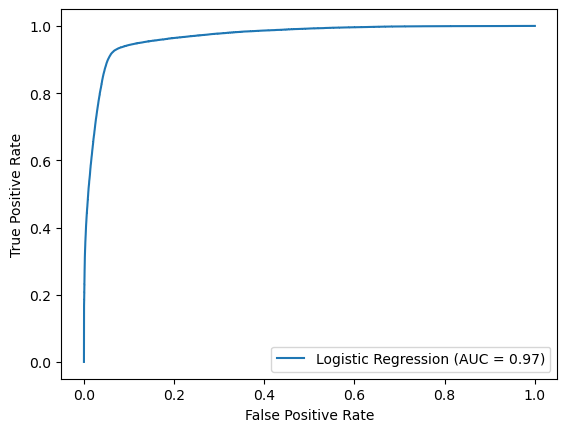

Random Forest - Accuracy: 0.9592
Random Forest - Precision: 0.8345
Random Forest - Recall: 0.8074
Random Forest - F1 Score: 0.8207


<Figure size 640x480 with 0 Axes>

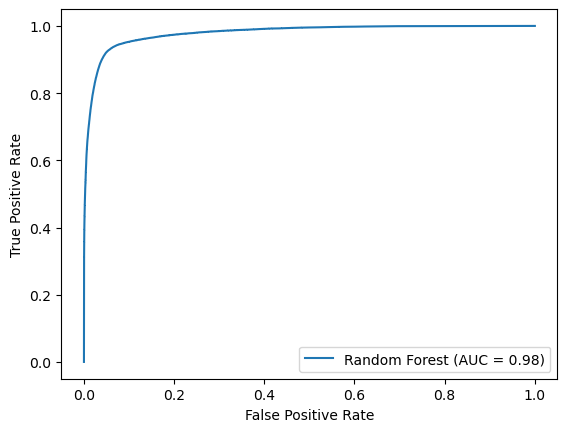

In [43]:
# Logistic Regression Evaluation
lr_metrics = evaluate_model_performance(best_lr, X_test, y_test, "Logistic Regression")

# Random Forest Evaluation
rf_metrics = evaluate_model_performance(best_rf, X_test, y_test, "Random Forest")

Random Forest - Accuracy: 0.9592
Random Forest - Precision: 0.8345
Random Forest - Recall: 0.8074
Random Forest - F1 Score: 0.8207


<Figure size 640x480 with 0 Axes>

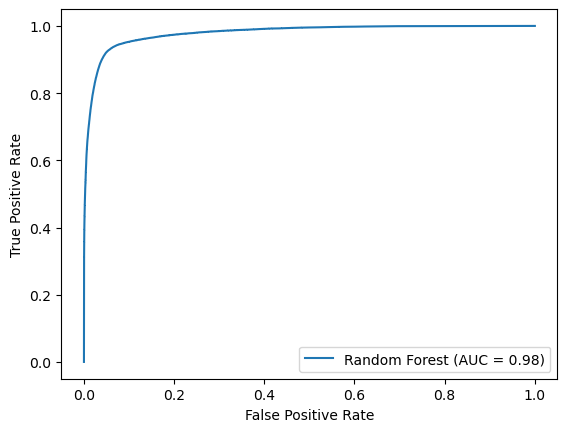

Training Accuracy: 0.9798
Test Accuracy: 0.9785


In [44]:
# Predict and evaluate on training data
y_train_pred = best_rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Use previously defined function to evaluate on test data
_, _, _, _, test_auc = evaluate_model_performance(best_rf, X_test, y_test, "Random Forest")

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_auc:.4f}")


In [156]:
feature_importances = best_rf.feature_importances_

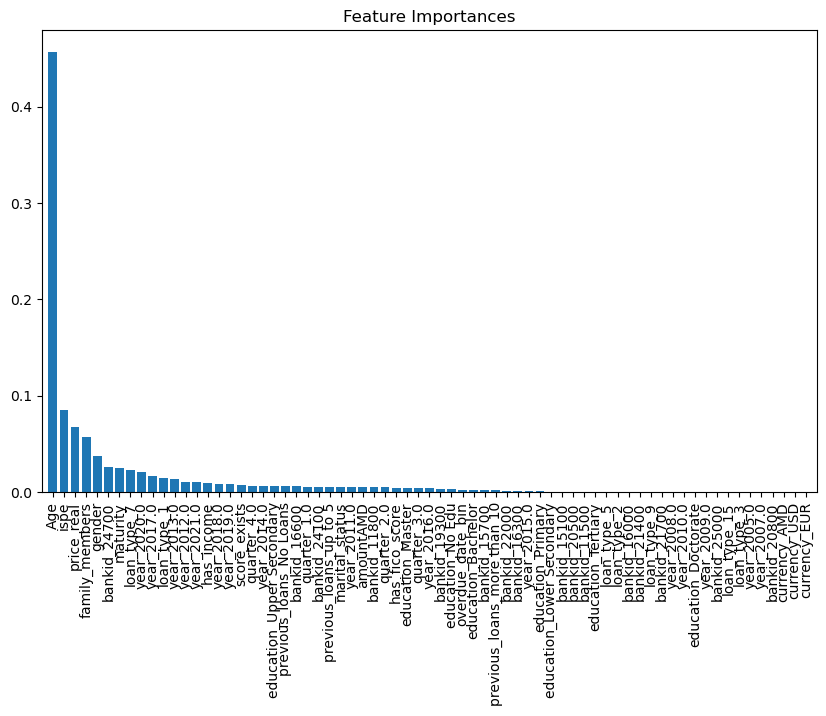

In [51]:
import matplotlib.pyplot as plt

feature_importances = best_rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


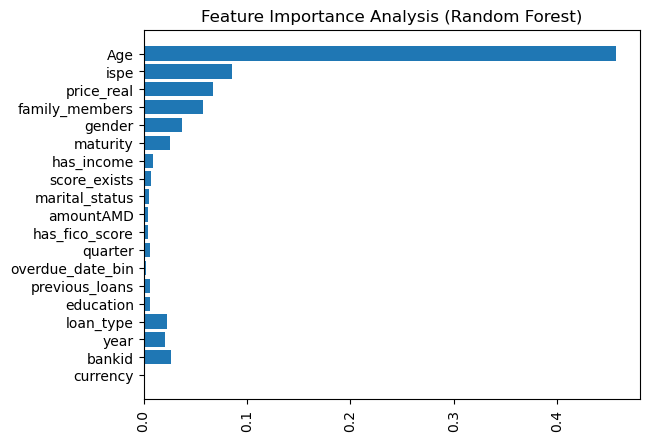

In [160]:
data_test2 = pd.DataFrame({'Feature' : feature_names, 'Coefficient': feature_importances})
def aggregate_features(row):
    if 'year' in row['Feature']:
        return 'year'
    elif 'bankid' in row['Feature']:
        return 'bankid'
    elif 'quarter' in row['Feature']:
        return 'quarter'
    elif 'loan_type' in row['Feature']:
        return 'loan_type'
    elif 'currency' in row['Feature']:
        return 'currency'
    elif 'education' in row['Feature']:
        return 'education'
    elif 'previous_loans' in row['Feature']:
        return 'previous_loans'    
    else: 
        return row['Feature']
    
data_test2['Feature'] = data_test2.apply(aggregate_features, axis = 1)
data_test2 = data_test2.sort_values('Coefficient')
data_test2['Coefficient'] = data_test2['Coefficient'].abs()
data_test2.reset_index(inplace = True, drop = True)
plt.barh(data_test2['Feature'], data_test2['Coefficient'])
plt.title('Feature Importance Analysis (Random Forest)')
plt.xticks(rotation = 90)
plt.show()

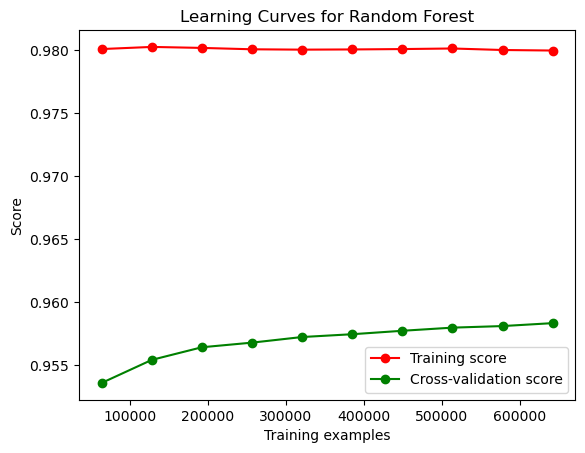

In [52]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    best_rf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curves for Random Forest')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()

In [53]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_rf, X_train, y_train, cv=5)
print("Cross-Validation Scores:", scores)
print("Average Cross-Validation Score:", np.mean(scores))

Cross-Validation Scores: [0.95788949 0.95896717 0.95897937 0.95792661 0.9580948 ]
Average Cross-Validation Score: 0.958371488196323


### XGBoost

In [57]:
import xgboost as xgb

In [58]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', use_label_encocder = False, eval_metric = 'logloss')

xgb_model.fit(X_train, y_train)

y_val_pred_xgb = xgb_model.predict(X_val)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("XGBoost Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_rf))
print("XGBoost Validation Classification Report:\n", classification_report(y_val, y_val_pred_rf))

XGBoost Validation Accuracy: 0.957566651342371
XGBoost Validation Confusion Matrix:
 [[231742   4883]
 [  6470  24454]]
XGBoost Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98    236625
           1       0.83      0.79      0.81     30924

    accuracy                           0.96    267549
   macro avg       0.90      0.89      0.89    267549
weighted avg       0.96      0.96      0.96    267549



In [59]:
param_grid = {
    'max_depth' : [3, 5, 7],
     'n_estimators' : [100, 200],
    'learning_rate' : [0.01, 0.1]
}

grid_search_xgb = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'binary:logistic', use_label_encoder = False, eval_metric ='logloss'),
                           param_grid = param_grid, scoring = 'accuracy', cv = 3, verbose = 0)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [60]:
# Best estimator
best_xgb = grid_search_xgb.best_estimator_
print("Best parameters:", grid_search_xgb.best_params_)

# Predict on the validation set using the best parameters
y_val_pred_best_xgb= best_xgb.predict(X_val)

# Evaluate the best Random Forest model
print("Tuned XGBooster Validation Accuracy:", accuracy_score(y_val, y_val_pred_best_xgb))
print("Tuned XGBooster Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_best_xgb))
print("Tuned XGBooster Validation Classification Report:\n", classification_report(y_val, y_val_pred_best_xgb))

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Tuned XGBooster Validation Accuracy: 0.9612370070529137
Tuned XGBooster Validation Confusion Matrix:
 [[231883   4742]
 [  5629  25295]]
Tuned XGBooster Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    236625
           1       0.84      0.82      0.83     30924

    accuracy                           0.96    267549
   macro avg       0.91      0.90      0.90    267549
weighted avg       0.96      0.96      0.96    267549



XGBoost - Accuracy: 0.9618
XGBoost - Precision: 0.8433
XGBoost - Recall: 0.8224
XGBoost - F1 Score: 0.8327


<Figure size 640x480 with 0 Axes>

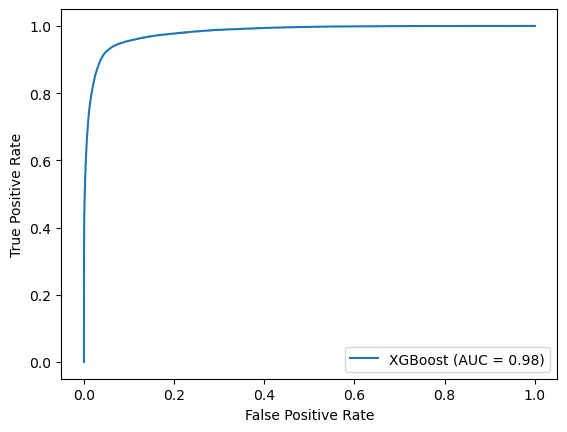

In [61]:
xgb_metrics = evaluate_model_performance(best_xgb, X_test, y_test, "XGBoost")

In [161]:
feature_importances = best_xgb.feature_importances_

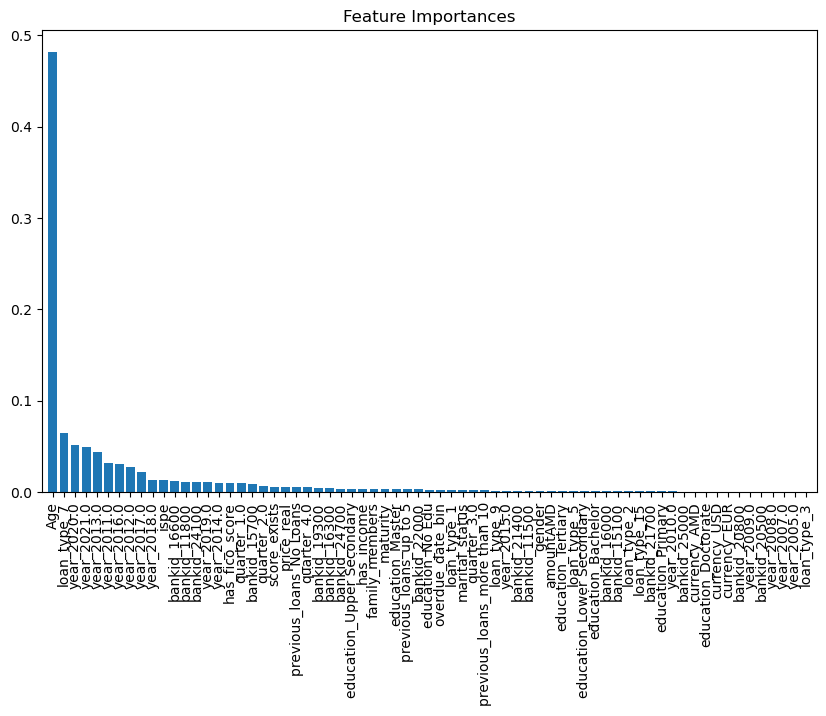

In [64]:
import matplotlib.pyplot as plt

feature_importances = best_xgb.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


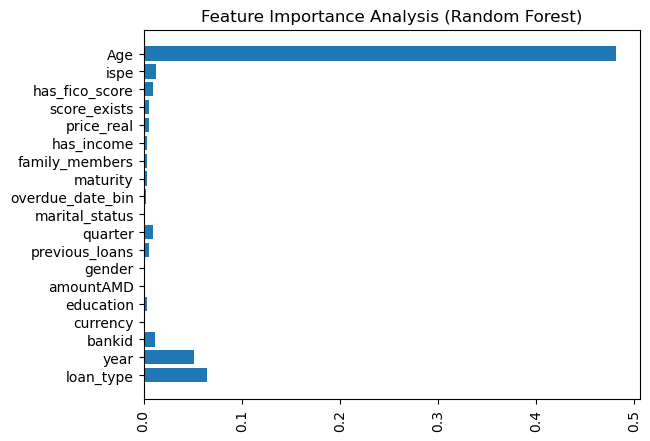

In [162]:
data_test3 = pd.DataFrame({'Feature' : feature_names, 'Coefficient': feature_importances})
def aggregate_features(row):
    if 'year' in row['Feature']:
        return 'year'
    elif 'bankid' in row['Feature']:
        return 'bankid'
    elif 'quarter' in row['Feature']:
        return 'quarter'
    elif 'loan_type' in row['Feature']:
        return 'loan_type'
    elif 'currency' in row['Feature']:
        return 'currency'
    elif 'education' in row['Feature']:
        return 'education'
    elif 'previous_loans' in row['Feature']:
        return 'previous_loans'    
    else: 
        return row['Feature']
    
data_test3['Feature'] = data_test3.apply(aggregate_features, axis = 1)
data_test3 = data_test3.sort_values('Coefficient')
data_test3['Coefficient'] = data_test3['Coefficient'].abs()
data_test3.reset_index(inplace = True, drop = True)
plt.barh(data_test3['Feature'], data_test3['Coefficient'])
plt.title('Feature Importance Analysis (Random Forest)')
plt.xticks(rotation = 90)
plt.show()

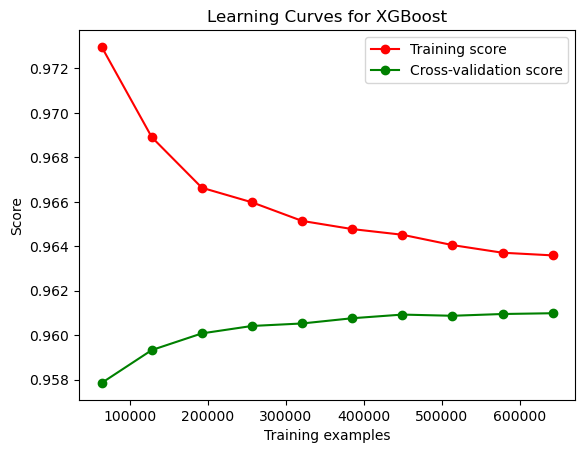

In [65]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    best_xgb, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curves for XGBoost')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()

In [66]:
scores = cross_val_score(best_xgb, X_train, y_train, cv=5)
print("Cross-Validation Scores:", scores)
print("Average Cross-Validation Score:", np.mean(scores))

Cross-Validation Scores: [0.9604996  0.9612845  0.96141507 0.96104131 0.96070492]
Average Cross-Validation Score: 0.9609890776319665


### The end